<img src="images/nvidia_header.png" style="margin-left: -30px; width: 300px; float: left;">

# Accelerating End-to-End Data Science Workflows # 

## 07 - Triton ##

**Table of Contents**
<br>
This notebook covers the process of deploying a model with Triton Inference Server and walks through the various tools available within Triton. This notebook covers the below sections: 
1. [Background](#s1)
2. [Preparing the Model](#s1)
    * [Load the Model](#s1)
    * [Creating the Folder Structure](#s1)
    * [Creating the Configuration File](#s1)
3. [Loading the Model in Triton](#s1)
    * [Starting Triton](#s1)
    * [Check Status of Triton Server](#s1)
4. [Testing Inference](#s1)
    * [Triton Client](#s1)
    * [Verifying Results for Local Model and Triton](#s1)
5. [Analyzing Performance](#s1)
    * [Customizing Perf Analyzer](#s1)
    * [Exercise #1 - Testing Perf Analyzer](#s1)
6. [Model Analyzer](#s1)


# Background
NVIDIA offers a framework for deploying ML models called Triton. Triton will automatically handle all inference requests that comes to the server. Triton supports multiple backends including PyTorch, TensorFlow, Forest Inference Library (FIL), etc. In this notebook, we will focus on the FIL backend using the xgboost model that was trained previously. 

## Preparing the Model
### Load the Model
Let's start with loading the previous XGBoost model.

In [1]:
import xgboost as xgb
model = xgb.Booster({'nthread': 4})  # init model
model.load_model('xgboost_model.json')  # load model data

### Creating the Folder Structure
In the previous notebook, we just saved the XGBoost model to the working directory. Triton expects the model to be in a particular structure: Model name should be the top level directory, and the version number should be next. This allows for multiple models and versions of those models to be hosted simulatenously. Let's create that folder structure and save the model!

In [2]:
import os

# Create the model repository directory. The name of this directory is arbitrary.
REPO_PATH = os.path.abspath('models')
os.makedirs(REPO_PATH, exist_ok=True)

# The name of the model directory determines the name of the model as reported by Triton
model_dir = os.path.join(REPO_PATH, "virus_prediction")

# We can store multiple versions of the model in the same directory. In our case, we have just one version, so we will add a single directory, named '1'.
version_dir = os.path.join(model_dir, '1')
os.makedirs(version_dir, exist_ok=True)

# The default filename for XGBoost models saved in json format is 'xgboost.json'.
# It is recommended that you use this filename to avoid having to specify a name in the configuration file.
model_file = os.path.join(version_dir, 'xgboost.json')
model.save_model(model_file)

### Creating the Configuration File
Triton also requires a configuration file that provides details about the model and deployment. For this notebook, we will assume default parameters.

In [3]:
config_text = f"""backend: "fil"
max_batch_size: {32768}
input [                                 
 {{  
    name: "input__0"
    data_type: TYPE_FP32
    dims: [ 4 ]                    
  }} 
]
output [
 {{
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }}
]
instance_group [{{ kind: KIND_GPU }}]
parameters [
  {{
    key: "model_type"
    value: {{ string_value: "xgboost_json" }}
  }},
  {{
    key: "output_class"
    value: {{ string_value: "false" }}
  }},
  {{
    key: "storage_type"
    value: {{ string_value: "AUTO" }}
  }}
]

dynamic_batching {{
  max_queue_delay_microseconds: 100
}}"""
config_path = os.path.join(model_dir, 'config.pbtxt')
with open(config_path, 'w') as file_:
    file_.write(config_text)

Now the model is ready to be loaded in Triton! The model repository should look like this.

```
model/
`-- virus_prediction
    |-- 1
    |   `-- xgboost.model
    `-- config.pbtxt
```


## Loading the Model in Triton
Next, we will need to start the Triton server. For this course, the server has already been started, but we will briefly go the steps required.

### Starting Triton
Triton is available as buildable source code or a pre-built docker image. For simplicity, we recommend that most users start with the docker images. This is how you would start the docker container in the console.

In [4]:
#!docker run --gpus=1 --rm -p 8000:8000 -p 8001:8001 -p 8002:8002 -v /full/path/to/docs/examples/model_repository:/models nvcr.io/nvidia/tritonserver:<xx.yy>-py3 tritonserver --model-repository=/models

Wow! That's a lot of inputs. Let's break it down a little bit more.

- **gpus=1** : Passes through the first GPU to the Triton Inference Server
- **rm** : Removes the container after completing execution
- **p 8000:8000** : Forwards the GTPCInferenceService Port
- **p 8001:8001** : Forwards the HTTPService Port
- **p 8002:8002** :  Forwards the Metrics Port
- **v /full/path/to/docs/examples/model_repository:/models** : Mounts the path to the models folder on the host machine to the Triton Inference Server container
- **nvcr.io/nvidia/tritonserver:<xx.yy>-py3** : Name of the Triton Inference Server image. The version number will change depending on the latest release
- **tritonserver --model-repository=/models**: The command to run in the container. In this case, we start the Triton Inference Server and point to the models folder


As we mentioned before, the server has already been started for this lab. Let's check our connection to the server! We are using "triton" as the hostname because the default docker network will resolve "triton" to the ip address of the Triton Inference Server.

In [5]:
!curl -v triton:8000/v2/health/ready

*   Trying 172.18.0.3:8000...
* Connected to triton (172.18.0.3) port 8000 (#0)
> GET /v2/health/ready HTTP/1.1
> Host: triton:8000
> User-Agent: curl/7.81.0
> Accept: */*
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< Content-Length: 0
< Content-Type: text/plain
< 
* Connection #0 to host triton left intact


Now let's see if the model has been loaded!

In [6]:
!curl -X POST http://triton:8000/v2/repository/index

[{"name":"virus_prediction","version":"1","state":"READY"}]

If all went well, we should be able to see the model "virus prediction" show up as ready.

## Testing Inference

### Triton Client
To test the deployment we will use the Triton Client library. Let's see how we can create an instance of the client. 

In [7]:
import time
import tritonclient.grpc as triton_grpc
from tritonclient import utils as triton_utils
HOST = "triton"
PORT = 8001
TIMEOUT = 60

In [8]:
client = triton_grpc.InferenceServerClient(url=f'{HOST}:{PORT}')

Now let's make sure the Triton server is ready by sending a sample inference request. First let's load the training data. We will only load 32768 rows, as that's the max batch size we specified.

In [9]:
import cudf 
import numpy as np
df = cudf.read_csv('./data/clean_uk_pop_full.csv', usecols=['age', 'sex', 'northing', 'easting', 'infected'], nrows=5000000)
df = df.sample(32768)
input_data = df.drop('infected', axis=1)
target = df[['infected']]
print(target)

         infected
3235714       0.0
4632197       0.0
4007136       0.0
4773598       0.0
1011063       0.0
...           ...
4591639       0.0
3752644       0.0
4866464       0.0
3081044       0.0
2325359       0.0

[32768 rows x 1 columns]


Now we convert it to a numpy array and force the type to be float32 (the same type we specified in the config file)

In [10]:
converted_df = input_data.to_numpy(dtype='float32')

Since we limited our batch size to 32768, let's splice the array and attempt the inference.

In [11]:
%%time
batched_data = converted_df[:32768]
# Prepare the input tensor
input_tensor = triton_grpc.InferInput("input__0", batched_data.shape, 'FP32')
input_tensor.set_data_from_numpy(batched_data)

# Prepare the output
output = triton_grpc.InferRequestedOutput("output__0")

# Send inference request
response = client.infer("virus_prediction", [input_tensor], outputs=[output])

# Get the output data
output_data = response.as_numpy("output__0")

CPU times: user 5.07 ms, sys: 383 μs, total: 5.46 ms
Wall time: 7.91 ms


Let's make sure the results we got were the same as with the local model.

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

xgb_data = xgb.DMatrix(input_data)
y_test = model.predict(xgb_data)

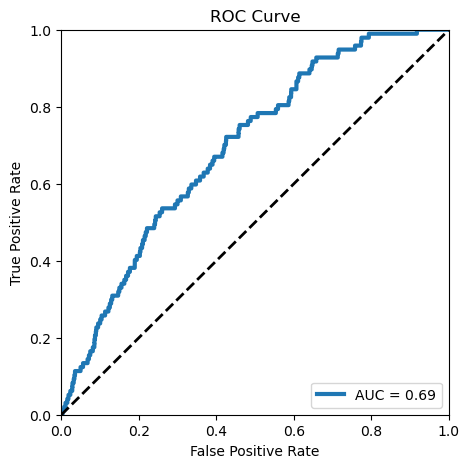

In [13]:
# Check that we got the same accuracy as previously
#target = target.to_numpy()
import matplotlib.pyplot as plt

false_pos_rate, true_pos_rate, thresholds = roc_curve(target.to_numpy(), y_test)
auc_result = auc(false_pos_rate, true_pos_rate)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(false_pos_rate, true_pos_rate, lw=3,
        label='AUC = {:.2f}'.format(auc_result))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc='lower right');
plt.show()


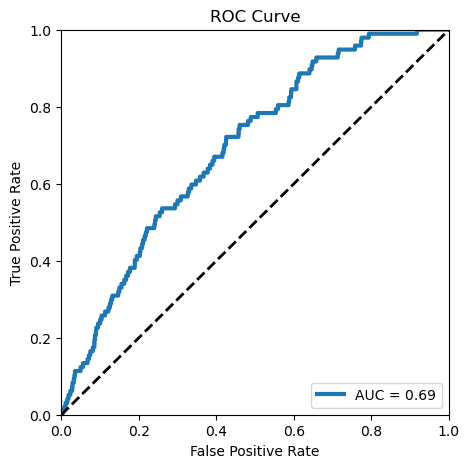

In [14]:
# Check that we got the same accuracy as previously
#target = target.to_numpy()
import matplotlib.pyplot as plt

false_pos_rate, true_pos_rate, thresholds = roc_curve(target.to_numpy(), output_data)
auc_result = auc(false_pos_rate, true_pos_rate)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(false_pos_rate, true_pos_rate, lw=3,
        label='AUC = {:.2f}'.format(auc_result))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc='lower right');
plt.show()

As we can see, our AUC score is the same between both inference options!

## Analyzing Performance

Earlier, we tested a *relatively* small inference request. What if we want to see the max throughput of the model? Luckily, Triton offers a performance analysis tool that generates synthetic data to collect latency and throughput numbers. Let's try it out.

In [15]:
!perf_analyzer -m virus_prediction -u "triton:8000"

*** Measurement Settings ***
  Batch size: 1
  Service Kind: TRITON
  Using "time_windows" mode for stabilization
  Stabilizing using average latency and throughput
  Measurement window: 5000 msec
  Using synchronous calls for inference

Request concurrency: 1
  Client: 
    Request count: 41473
    Throughput: 2294.91 infer/sec
    Avg latency: 432 usec (standard deviation 110 usec)
    p50 latency: 420 usec
    p90 latency: 579 usec
    p95 latency: 626 usec
    p99 latency: 679 usec
    Avg HTTP time: 427 usec (send/recv 44 usec + response wait 383 usec)
  Server: 
    Inference count: 41473
    Execution count: 41473
    Successful request count: 41473
    Avg request latency: 283 usec (overhead 1 usec + queue 196 usec + compute input 22 usec + compute infer 44 usec + compute output 19 usec)

Inferences/Second vs. Client Average Batch Latency
Concurrency: 1, throughput: 2294.91 infer/sec, latency 432 usec


That's a lot of information to take in. Let's break it down.

**Measurement window**: Timeframe that measurements are taken in 

**Batch Size**: Number of inputs in each request


**Concurrency**: Number of simulatenous connections
**Latency**: Time taken to recieve results
**p50/90/95/99**: Different percentiles for latency

Based on these results, we can see that our throughput is roughly ~2300 inferences per second with a single concurrent connection, and the average latency for each requst is 434 usec.

# Customizing Perf Analyzer
The Performance Analyzer tool for Triton has many knobs that can be turned to analyze results. Let's enable GPU metric collection, and increase the batch size and concurrency range values!

In [16]:
!perf_analyzer --collect-metrics -m virus_prediction -u "triton:8000" -b 8 --concurrency-range 2:8:2

*** Measurement Settings ***
  Batch size: 8
  Service Kind: TRITON
  Using "time_windows" mode for stabilization
  Stabilizing using average latency and throughput
  Measurement window: 5000 msec
  Latency limit: 0 msec
  Concurrency limit: 8 concurrent requests
  Using synchronous calls for inference

Request concurrency: 2
  Client: 
    Request count: 83468
    Throughput: 36650.2 infer/sec
    Avg latency: 433 usec (standard deviation 112 usec)
    p50 latency: 426 usec
    p90 latency: 591 usec
    p95 latency: 625 usec
    p99 latency: 708 usec
    Avg HTTP time: 428 usec (send/recv 41 usec + response wait 387 usec)
  Server: 
    Inference count: 667744
    Execution count: 41849
    Successful request count: 83468
    Avg request latency: 273 usec (overhead 1 usec + queue 180 usec + compute input 22 usec + compute infer 44 usec + compute output 25 usec)

  Server Prometheus Metrics: 
    Avg GPU Utilization:
      GPU-0c302de4-8095-218d-670b-a754c3686020 : 1%
      GPU-2d1b53c

The results show that our model configuration gives a throughput of about ~156171 inferences per second. Notice how there are significant throughput gains as we increase the number of concurrent connections. With low concurrency values, Triton is idle during the time when the response is returned to the client and the next request is received at the server. Throughput increases when we increase concurrency values because Triton overlaps the processing of one request with the communication of the other. 

# Exercise 
Please take this time to experiment with the perf analyzer tool. A full list of parameters can be seen with the --help argument. Some parameters that we recommend trying out are listed below. 

-b <value> : batch size
--concurrency-range <start:end:step> : range of concurrency values to test
--collect-metrics : enable collection of GPU metrics

In [ ]:
!perf_analyzer --collect-metrics -m virus_prediction -u "triton:8000" -b 10 --concurrency-range 2:8:2

*** Measurement Settings ***
  Batch size: 10
  Service Kind: TRITON
  Using "time_windows" mode for stabilization
  Stabilizing using average latency and throughput
  Measurement window: 5000 msec
  Latency limit: 0 msec
  Concurrency limit: 8 concurrent requests
  Using synchronous calls for inference

Request concurrency: 2
  Client: 
    Request count: 84233
    Throughput: 46306.4 infer/sec
    Avg latency: 428 usec (standard deviation 112 usec)
    p50 latency: 416 usec
    p90 latency: 582 usec
    p95 latency: 631 usec
    p99 latency: 679 usec
    Avg HTTP time: 423 usec (send/recv 44 usec + response wait 379 usec)
  Server: 
    Inference count: 842310
    Execution count: 42215
    Successful request count: 84233
    Avg request latency: 297 usec (overhead 1 usec + queue 197 usec + compute input 24 usec + compute infer 46 usec + compute output 28 usec)

  Server Prometheus Metrics: 
    Avg GPU Utilization:
      GPU-0c302de4-8095-218d-670b-a754c3686020 : 1%
      GPU-2d1b53

## Model Analyzer
Although it is out of scope for this course, we would like to introduce the Model Analyzer tool that is available as part of Triton. This tool searches through different parameter configurations to find optimal parameters that maximize inference throughput. With some minor processing, results can be viewed in a PDF format as well. The syntax for running Model Analyzer is shown below, as well as an example of the output. Model Analyz

In [ ]:
#%%bash
## Writing constraints to file
#cat > model_analyzer_constraints.yaml <<EOL 
#model_repository: /model_repository/
#triton_launch_mode: "local"
#latency_budget: 5
#run_config_search_max_concurrency: 64
#run_config_search_max_instance_count: 3
#run_config_search_max_preferred_batch_size: 8
#profile_models:
#  virus_prediction
#
#EOL

In [ ]:
# Run model_analyzer profiler on XGBoost model 
#!model-analyzer profile -f model_analyzer_constraints.yaml --override-output-model-repository

![image](images/model_analyzer.png)

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

**Well Done!** Let's move to the [next notebook](3-08_k-means_dask.ipynb). 

<img src="images/nvidia_header.png" style="margin-left: -30px; width: 300px; float: left;">